In [1]:
import pandas as pd

df1 = pd.read_excel('f_029df.xlsx')
df2 = pd.read_excel('f_9218df.xlsx')
df3 = pd.read_excel('f_18224df.xlsx')


In [2]:
df1.head()

,Unnamed: 0,Unnamed: 0.1,dong,X,Y,highway,ffnc,ffc,nfnc,nfc,fsnc,fsc,nsnc,nsc,총생활인구수,affnc,affc,anfnc,anfc,afsnc,afsc,ansnc,ansc
0,0,0,가락1동,127.108235,37.495329,0.0,0.225806,0.000000,0.00,0.0,0.164634,0.000000,0.02,0.000000,0.322362,0.077419,0.000000,0.00,0.000000,0.047561,0.022764,0.012,0.034783
1,1,1,가락2동,127.130643,37.495860,0.0,0.161290,0.166667,0.00,0.0,0.024390,0.016260,0.08,0.000000,0.320622,0.038710,0.033333,0.01,0.033333,0.056098,0.043902,0.064,0.130435
2,2,2,가락본동,127.121640,37.497217,0.0,0.032258,0.000000,0.00,0.0,0.146341,0.154472,0.04,0.260870,0.445918,0.045161,0.033333,0.01,0.033333,0.040244,0.040650,0.064,0.078261
3,3,3,가리봉동,126.888257,37.482555,0.0,0.032258,0.000000,0.05,0.0,0.006098,0.000000,0.74,0.000000,0.108998,0.283871,0.000000,0.08,0.233333,0.293902,0.034146,0.392,0.234783
4,4,4,가산동,126.884341,37.476835,0.0,1.000000,0.000000,0.20,1.0,1.000000,0.065041,0.86,0.913043,0.562965,0.335484,0.000000,0.12,0.233333,0.343902,0.058537,0.408,0.286957


In [3]:
# 필요없는 column 삭제
df1 = df1.drop('Unnamed: 0', axis = 1)
df1 = df1.drop('Unnamed: 0.1', axis = 1)
df1 = df1.drop('X', axis = 1)
df1 = df1.drop('Y', axis = 1)

df2 = df2.drop('Unnamed: 0', axis = 1)
df2 = df2.drop('Unnamed: 0.1', axis = 1)
df2 = df2.drop('X', axis = 1)
df2 = df2.drop('Y', axis = 1)

df3 = df3.drop('Unnamed: 0', axis = 1)
df3 = df3.drop('Unnamed: 0.1', axis = 1)
df3 = df3.drop('X', axis = 1)
df3 = df3.drop('Y', axis = 1)

In [4]:
# 전에 heatmap을 그린것을 보면 ffc는 데이터가 너무 없어서 -값 내지는 매우 작은값을 보였습니다.
# 머신러닝돌릴때는 ffc와 affc도 drop합시다.
df2 = df2.drop('ffc', axis = 1)
df2 = df2.drop('affc', axis = 1)

In [5]:
# null값을 0으로 채워둡니다.
df2 = df2.fillna(0)

In [8]:
a = df2['총생활인구수'].values
df2 = df2.drop('총생활인구수', axis = 1)
df2['population'] = a

In [10]:
df2

,dong,highway,ffnc,nfnc,nfc,fsnc,fsc,nsnc,nsc,affnc,anfnc,anfc,afsnc,afsc,ansnc,ansc,population
0,가락1동,0.0,0.225806,0.00,0.000000,0.164634,0.000000,0.02,0.000000,0.077419,0.00,0.000000,0.047561,0.022764,0.012,0.034783,0.155581
1,가락2동,0.0,0.161290,0.00,0.000000,0.024390,0.016260,0.08,0.000000,0.038710,0.01,0.033333,0.056098,0.043902,0.064,0.130435,0.154967
2,가락본동,0.0,0.032258,0.00,0.000000,0.146341,0.154472,0.04,0.260870,0.045161,0.01,0.033333,0.040244,0.040650,0.064,0.078261,0.264574
3,가리봉동,0.0,0.032258,0.05,0.000000,0.006098,0.000000,0.74,0.000000,0.283871,0.08,0.233333,0.293902,0.034146,0.392,0.234783,0.062857
4,가산동,0.0,1.000000,0.20,1.000000,1.000000,0.065041,0.86,0.913043,0.335484,0.12,0.233333,0.343902,0.058537,0.408,0.286957,0.636785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,효창동,0.0,0.000000,0.00,0.000000,0.073171,0.056911,0.00,0.086957,0.025806,0.00,0.000000,0.067073,0.060163,0.032,0.208696,0.041038
420,후암동,0.0,0.000000,0.00,0.000000,0.030488,0.000000,0.00,0.043478,0.051613,0.08,0.000000,0.029268,0.024390,0.040,0.026087,0.062667
421,휘경1동,0.0,0.000000,0.00,0.000000,0.042683,0.024390,0.00,1.000000,0.038710,0.07,0.033333,0.053659,0.099187,0.016,0.234783,0.093562
422,휘경2동,0.0,0.096774,0.10,0.166667,0.030488,0.073171,0.04,0.173913,0.032258,0.05,0.033333,0.064634,0.091057,0.024,0.286957,0.093976


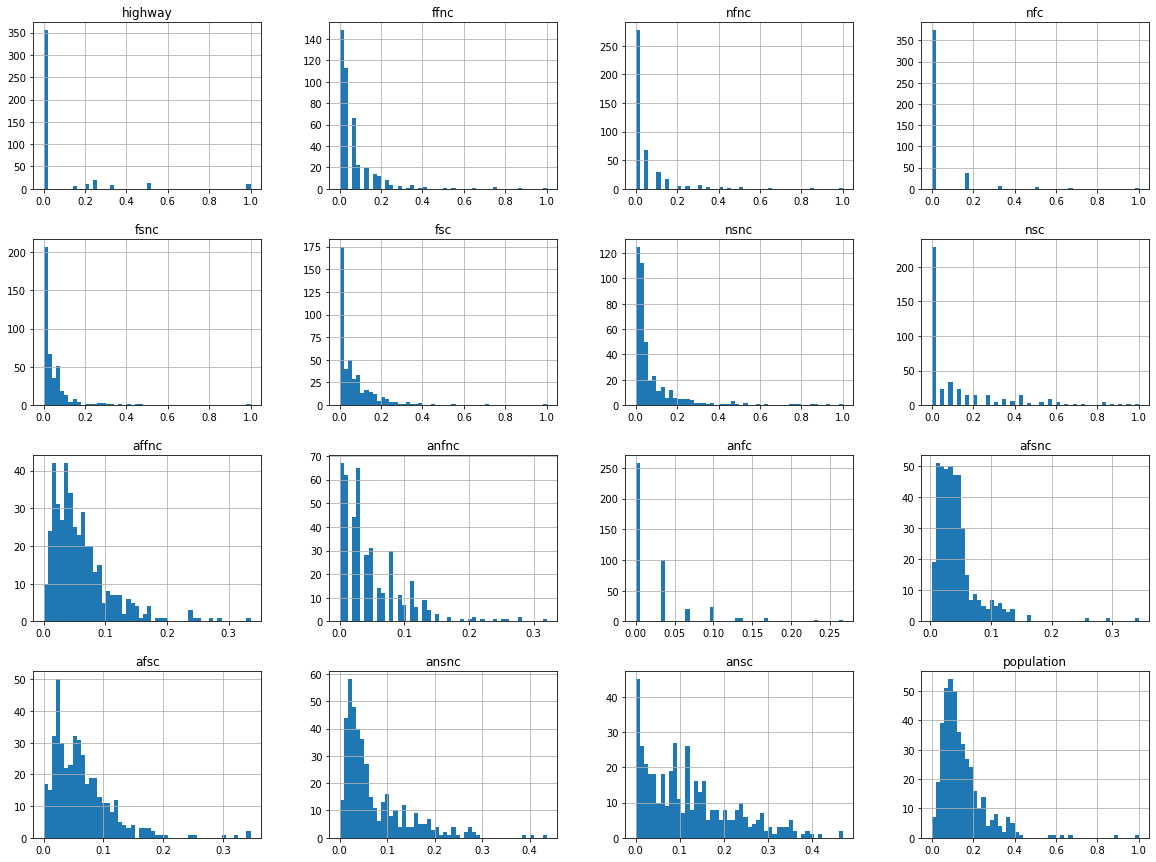

In [12]:
# 데이터들의 histgram을 봅시다.
import matplotlib.pyplot as plt
df2.hist(bins = 50, figsize = (20,15))
plt.show()

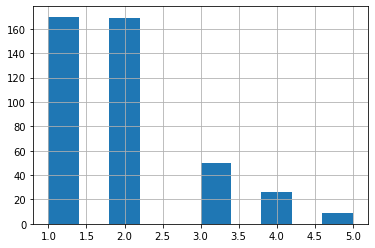

In [19]:
# population 데이터가 class값으로 들어가게 될것입니다.
# 우리는 population data를 치우치지 않게 여러 set 뽑아주는 StratifiedKFold를 하고 싶습니다.
# population을 5개의 구역으로 나눠줬습니다. kfold를 할때 각 구역에서 일정한 값들이 뽑히게 할것입니다.

# pd.cut을 이용하여 population을 5개의 구역으로 나눈것을 pop_cut이라는 column에 담았습니다,
df2["pop_cat"] = pd.cut(df2["population"],
                              bins = [-1.0, 0.1, 0.2, 0.3, 0.4, 1.1],
                              labels = [1.0, 2.0, 3.0, 4.0, 5.0])
df2["pop_cat"].hist()

In [20]:
# average, standard deviation
import numpy as np
a = [1,3,5,7,9]
b = sum(a)/5
c = b*np.ones(5)
d = np.sqrt(sum((a - c)**2)/5)
print(b)
print(d)

5.0
2.8284271247461903


In [21]:
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

# seed를 정해줍니다.
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

data = df2.values
x = data[:,1:-2].astype(float)  # feature
y = data[:,-2].astype(float)   # population
y_cat = data[:,-1].astype(float) # pop_cut

#  StratifiedKFold
n_fold = 5
skf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)
  
# 에러를 담기위해 먼저 빈 array를 만들었습니다.  
test_error_set = []  
train_error_set = [] 

# valiation loss가 patience만큼 반복해도 변하지 않거나 나빠지면 학습을 중단하게 설정합니다.  
# patience 조정가능!
ESC = EarlyStopping(monitor = 'val_loss', patience = 5) 

for train, test in skf.split(x,y_cat): # StratifiedKFold로 나눈 데이터 셋을 받습니다. n_fold가 5이므로 for문은 5번 돌것입니다.
  model = Sequential()
  model.add(Dense(7,input_dim = 15, activation= 'relu'))
  model.add(Dense(1,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])
  # fold별로 error를 받아줘서 위에 만든 빈 array에 담아줍니다.
  train_error = mean_squared_error(y[train], model.predict(x[train])) 
  test_error = mean_squared_error(y[test], model.predict(x[test]))
  train_error_set.append(train_error)
  test_error_set.append(test_error)
# error들의 평균과 표준편차를 구해줍니다.
average_train_error = sum(train_error_set)/5
ate1 = average_train_error*np.ones(5)
train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
average_test_error = sum(test_error_set)/5
ate2 = average_test_error*np.ones(5)
test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

print('train:',average_train_error,train_standard_deviation)
print('test:',average_test_error,test_standard_deviation)



Epoch 1/300
28/28 [==============================] - 1s 8ms/step - loss: 0.0357 - val_loss: 0.0240
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0192
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0161
Epoch 4/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0183 - val_loss: 0.0141
Epoch 5/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0129
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0122
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0119
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 9/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 10/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 11/

In [23]:
# 위에서 만든 모델을 바탕으로 layer 수와 node 갯수를 변수로 받는 함수를 만들어줍니다.

def construct_layer(layer_num,node_num):
  test_error_set = []  
  train_error_set = []  
  
  for train, test in skf.split(x,y_cat):
    model = Sequential()
    model.add(Dense(node_num,input_dim = 15, activation= 'relu'))
    model.add(Dense(layer_num,activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
    model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])
    train_error = mean_squared_error(y[train], model.predict(x[train]))
    test_error = mean_squared_error(y[test], model.predict(x[test]))
    train_error_set.append(train_error)
    test_error_set.append(test_error)
  
  average_train_error = sum(train_error_set)/5
  ate1 = average_train_error*np.ones(5)
  train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
  average_test_error = sum(test_error_set)/5
  ate2 = average_test_error*np.ones(5)
  test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

  return [average_train_error, train_standard_deviation,average_test_error,test_standard_deviation]  

In [24]:
a = construct_layer(1,15)
print(a)
#결과가 list로 잘 출력이 되네요!

Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.0338 - val_loss: 0.0238
Epoch 2/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0191
Epoch 3/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0161
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0141
Epoch 5/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0129
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0122
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.0119
Epoch 8/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0118
Epoch 9/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 10/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 11/

In [30]:
x_arr = [] # train error
y_arr = [] # test error
# hidden layer의 node수를 7로 해두고 층을 계속 쌓았을때 loss가 어떻게 변하는지 그려봅시다.
max_layer = 20
for i in range(0,max_layer):
  a = construct_layer(i,16)
  x_arr.append(a[0])
  y_arr.append(a[2])
  print('layer:',i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0320
layer: 0
Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 0.0072
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 3/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0089 - val_loss: 0.0068
Epoch 5/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 9/300
28/28 [==============================] - 0s 3ms/step

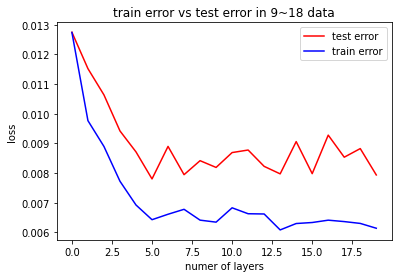

In [33]:
# plot
n = np.arange(0,max_layer)
plt.plot(n,y_arr,c = 'red', label ='test error') 

plt.plot(n,x_arr,c = 'blue', label = 'train error')
plt.xlabel('numer of layers')
plt.ylabel('loss')
plt.title('train error vs test error in 9~18 data')
plt.savefig('train error vs test error in 9~18')
plt.legend()

In [32]:
#
for train, test in skf.split(x,y_cat): 
  model = Sequential()
  model.add(Dense(15,input_dim = 15, activation= 'relu'))
  model.add(Dense(5,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])

Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.0326 - val_loss: 0.0226
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.0164
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 0.0123
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0103
Epoch 5/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0097
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0095
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 9/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 10/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 11/

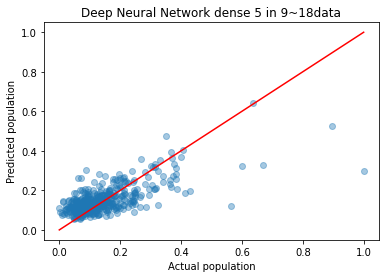

In [36]:
# plot

# about last fold
# y_predict = model.predict(x[test])

# about all data
y_predict = model.predict(x) 

import matplotlib.pyplot as plt
# about last fold
# plt.scatter(y[test], y_predict, alpha=0.4)

# about all data
plt.scatter(y, y_predict, alpha=0.4)

plt.plot([0,1],[0,1], c = 'red')
plt.xlabel("Actual population")
plt.ylabel("Predicted population")
plt.title("Deep Neural Network dense 5 in 9~18data")
plt.savefig('DNN_test_9~18.png')
plt.show() 

In [37]:
list_y = y.tolist()
list_predicty = []

for i in range(len(list_y)):
    list_predicty.append(y_predict[i].item())
diff = []
for i in range(len(list_y)):
    diff.append(list_y[i] - list_predicty[i])
diff

[-0.025427261387767103,
 0.015011827638151926,
 0.09854896910062222,
 -0.19763365622241869,
 -0.0030823200661181938,
 0.03190299296161131,
 -0.029386641194092233,
 -0.05461767241395423,
 -0.07766011513046063,
 0.05319204924353285,
 -0.006664072882143296,
 0.05674409369903785,
 0.06193246865267055,
 0.04537145482306715,
 -0.04519044384733473,
 -0.05795901245078215,
 0.03296877052253391,
 -0.06114655392039196,
 -0.054952064686465456,
 -0.19400756865393318,
 -0.040165065402969824,
 -0.03819148965482967,
 -0.08896184179378311,
 -0.13329519802976011,
 0.05930355216227498,
 0.04978774438866462,
 -0.06294721632002293,
 -0.05477068214397221,
 0.036837915055922515,
 0.04097708344454554,
 -0.11757445459147167,
 -0.009205571650971661,
 0.07140087276354229,
 0.04622973825808363,
 -0.08463762170003503,
 -0.024147093814410076,
 0.010040831571685366,
 0.051719791561615075,
 0.008971304544065903,
 -0.07204776057254028,
 0.01828470454736504,
 -0.0699585074578752,
 -0.08864763515435456,
 -0.059883041738

In [38]:
df2['diff'] = diff

In [39]:
df2.head()

,dong,highway,ffnc,nfnc,nfc,fsnc,fsc,nsnc,nsc,affnc,anfnc,anfc,afsnc,afsc,ansnc,ansc,population,pop_cat,diff
0,가락1동,0.0,0.225806,0.00,0.0,0.164634,0.000000,0.02,0.000000,0.077419,0.00,0.000000,0.047561,0.022764,0.012,0.034783,0.155581,2.0,-0.025427
1,가락2동,0.0,0.161290,0.00,0.0,0.024390,0.016260,0.08,0.000000,0.038710,0.01,0.033333,0.056098,0.043902,0.064,0.130435,0.154967,2.0,0.015012
2,가락본동,0.0,0.032258,0.00,0.0,0.146341,0.154472,0.04,0.260870,0.045161,0.01,0.033333,0.040244,0.040650,0.064,0.078261,0.264574,3.0,0.098549
3,가리봉동,0.0,0.032258,0.05,0.0,0.006098,0.000000,0.74,0.000000,0.283871,0.08,0.233333,0.293902,0.034146,0.392,0.234783,0.062857,1.0,-0.197634
4,가산동,0.0,1.000000,0.20,1.0,1.000000,0.065041,0.86,0.913043,0.335484,0.12,0.233333,0.343902,0.058537,0.408,0.286957,0.636785,5.0,-0.003082


In [ ]:
a = df1['diff'].sort_values()

In [42]:
df2_sort = df2.sort_values(by = df2.columns[-1], ascending= False )

In [43]:
df2_sort

,dong,highway,ffnc,nfnc,nfc,fsnc,fsc,nsnc,nsc,affnc,anfnc,anfc,afsnc,afsc,ansnc,ansc,population,pop_cat,diff
278,역삼1동,0.00,0.129032,0.05,0.000000,0.103659,0.211382,0.36,0.173913,0.058065,0.15,0.033333,0.060976,0.167480,0.164,0.252174,1.000000,5.0,0.701334
187,서교동,0.00,0.000000,0.00,0.000000,0.006098,0.073171,0.06,0.000000,0.032258,0.04,0.000000,0.017073,0.048780,0.032,0.078261,0.564476,5.0,0.443535
277,여의동,1.00,0.870968,0.45,0.166667,0.414634,0.154472,0.46,0.608696,0.238710,0.19,0.033333,0.109756,0.092683,0.212,0.234783,0.896263,5.0,0.372292
353,종로1.2.3.4가동,0.00,0.290323,0.15,0.166667,0.378049,0.000000,0.12,0.391304,0.270968,0.17,0.033333,0.081707,0.008130,0.160,0.095652,0.670800,5.0,0.344148
193,서초3동,0.25,0.225806,0.05,0.000000,0.231707,0.284553,0.14,0.521739,0.109677,0.05,0.000000,0.081707,0.089431,0.116,0.200000,0.598984,5.0,0.276695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,돈암2동,0.00,0.032258,0.10,0.000000,0.073171,0.390244,0.02,0.086957,0.019355,0.04,0.000000,0.053659,0.120325,0.104,0.069565,0.047493,1.0,-0.136913
117,묵1동,0.00,0.129032,0.05,0.000000,0.030488,0.203252,0.76,0.695652,0.038710,0.08,0.000000,0.051220,0.087805,0.172,0.400000,0.130530,2.0,-0.150274
19,거여2동,0.00,0.064516,0.05,0.000000,0.000000,0.081301,0.94,0.086957,0.077419,0.08,0.133333,0.019512,0.056911,0.284,0.121739,0.070061,1.0,-0.194008
3,가리봉동,0.00,0.032258,0.05,0.000000,0.006098,0.000000,0.74,0.000000,0.283871,0.08,0.233333,0.293902,0.034146,0.392,0.234783,0.062857,1.0,-0.197634


In [46]:
df2_sort.to_excel('sort_9218df.xlsx')